try with series column and three classes and ['BallFault', 'InnerFault', 'outerFault'] and two features speed , and vibration with accuracy of 86% with dropouts rows of same records in speed and vibration. now i make take equal distribution of classes with diffrent batch_size 


In [1]:

#moving avg window
#datasetdir = "../datasets/allfaultdatasetfiltered13.csv"
figuredir = "../figures/MLPv13/"

import os

# You should change 'test' to your preferred folder.
#CHECK_FOLDER = os.path.isdir(datasetdir)

# You should change 'test' to your preferred folder.
CHECK_FOLDER = os.path.isdir(figuredir)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(figuredir)
    print("created folder : ", figuredir)

else:
    print(figuredir, "folder already exists.")


../figures/MLPv13/ folder already exists.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
plt.rcParams["figure.figsize"] = (15,8)

In [3]:
#df = pd.read_csv("../datasets/allfaultdatasetfiltered13.csv")
## to rename outerfault 
df = pd.read_csv("../datasets/allfaultdatasetfiltered13.csv", index_col ="class" )
"""Droping Series Column which is no longer required 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

df.drop(['B', 'C'], axis=1)

also rearrange columns order
df = df[['speed','vibration','Faults']]

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html
#df.rename(columns={"A": "a", "B": "c"})
"""
df = df.drop(['series'], axis=1)
df = df.rename(index={'BallFault':'Ball'})
df = df.rename(index={'InnerFault':'Innerrace'})
df = df.rename(index={'outerFault':'Outerrace'})
df = df.reset_index()
df = df.rename(columns  ={'class':'Faults'})
df = df[['speed','vibration','Faults']]
df.head() , df['Faults'].unique()


(      speed  vibration Faults
 0  4.217042   0.003062   Ball
 1  4.219672   0.004049   Ball
 2  4.221645   0.001418   Ball
 3  0.036346  -0.002199   Ball
 4  0.036017  -0.003515   Ball,
 array(['Ball', 'Innerrace', 'Outerrace'], dtype=object))

In [4]:
#Re ordering column

#df = df[["speed", "vibration", "series", "class"]]

In [5]:
df.info

<bound method DataFrame.info of             speed  vibration     Faults
0        4.217042   0.003062       Ball
1        4.219672   0.004049       Ball
2        4.221645   0.001418       Ball
3        0.036346  -0.002199       Ball
4        0.036017  -0.003515       Ball
...           ...        ...        ...
5667608  4.202576  -0.004830  Outerrace
5667609  4.198959  -0.003515  Outerrace
5667610  4.279838  -0.002857  Outerrace
5667611  0.037332  -0.006146  Outerrace
5667612  0.037661  -0.009105  Outerrace

[5667613 rows x 3 columns]>

In [6]:
#healthy = healthy.rename(columns={"vsH": "speed", "vbH": "vibration"})

In [7]:
# it change style and colour for graph 
#from yellowbrick.classifier import ClassificationReport
## OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)
plt.rcParams['agg.path.chunksize'] = 100000

sns.countplot(x = 'Faults', data=df )

# to save plots in high ddefinition 
#plt.savefig("../figures/class_distribution_beforedropouts.png")
plt.ylabel("Records")
plt.savefig("../figures/class_distribution_beforedropouts.png", bbox_inches='tight', dpi=1200)
plt.show()

In [8]:
#df['Faults'].unique()

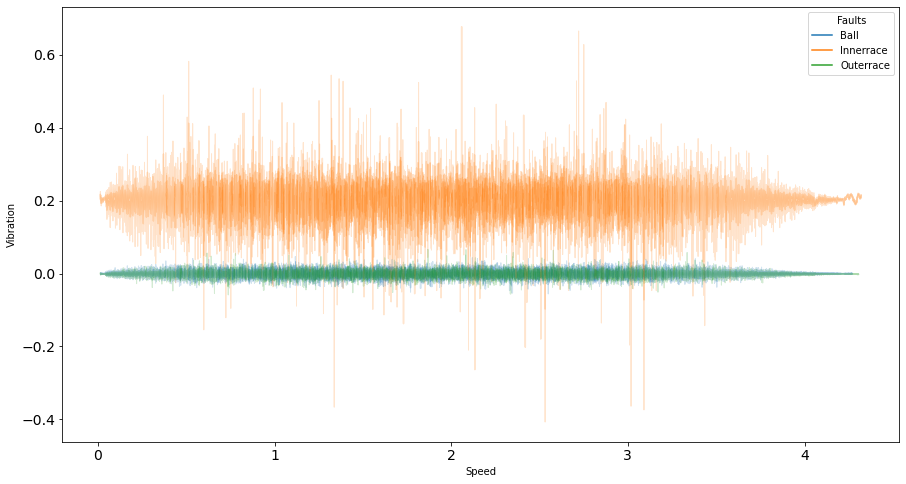

In [9]:
#df['vibration'].plot(color='b',figsize = (8,8))

g = sns.lineplot(x="speed", y="vibration",hue= 'Faults',
                data=df.reset_index(), palette="tab10" , alpha = 0.2)

plt.legend(loc=2)
plt.ylabel("Vibration")
plt.xlabel("Speed")
plt.tick_params(axis='both',labelsize=14)

g.legend(loc= 'upper right')
g.legend_.set_title('Faults')

plt.savefig("../figures/vibration vs speed.png", bbox_inches='tight', dpi=600)

sns.boxplot(x = 'Faults',y = 'vibration', data=df.reset_index())

#df['vibration'].plot(color='b',figsize = (8,8))

g = sns.lineplot(x="index", y="vibration",hue= 'Faults',
                data=df.reset_index(), palette="tab10")

plt.legend(loc=2)
plt.ylabel("Vibration")
plt.xlabel("Timestamp")
plt.tick_params(axis='both',labelsize=14)

g.legend(loc= 'upper right')
g.legend_.set_title('Faults')

plt.savefig("../figures/vibration_beforedropouts.png", bbox_inches='tight', dpi=1200)

In [10]:
df = df.drop_duplicates(subset = ["speed", 'vibration'])

print(df)

            speed  vibration     Faults
0        4.217042   0.003062       Ball
1        4.219672   0.004049       Ball
2        4.221645   0.001418       Ball
3        0.036346  -0.002199       Ball
4        0.036017  -0.003515       Ball
...           ...        ...        ...
5667456  4.151615  -0.016340  Outerrace
5667459  2.739196  -0.009105  Outerrace
5667542  3.131096  -0.001213  Outerrace
5667560  1.329083  -0.000555  Outerrace
5667578  0.155362   0.001747  Outerrace

[757558 rows x 3 columns]


sns.countplot(x = 'Faults', data=df)

# to save plots in high ddefinition 
#plt.savefig("../figures/class_distribution_beforedropouts.png")
plt.ylabel("Records")
plt.savefig(figuredir + "class_distribution_afterdropouts.png", bbox_inches='tight', dpi=600)
plt.show()

In [12]:
#['BallFault', 'InnerFault', 'outerFault']

BallFaultlenght = len(df[df['Faults']=='Ball'])
InnerFaultlenght = len(df[df['Faults']=='Innerrace'])
outerFaultlenght = len(df[df['Faults']=='Outerrace'])


#BallFaultlenght = 20000
#InnerFaultlenght = 20000 
#outerFaultlenght = 20000

print(BallFaultlenght)
print(InnerFaultlenght)
print(outerFaultlenght)

203913
451728
101917


In [13]:

newBallFault = df[df['Faults']=='Ball'].iloc[0:outerFaultlenght]
newInnerFault = df[df['Faults']=='Innerrace'].iloc[0:outerFaultlenght]
newouterFault = df[df['Faults']=='Outerrace'].iloc[0:outerFaultlenght]


newBallFault , newInnerFault , newouterFault

(           speed  vibration Faults
 0       4.217042   0.003062   Ball
 1       4.219672   0.004049   Ball
 2       4.221645   0.001418   Ball
 3       0.036346  -0.002199   Ball
 4       0.036017  -0.003515   Ball
 ...          ...        ...    ...
 722641  4.187452  -0.021273   Ball
 722642  4.264386  -0.022588   Ball
 722651  4.092436  -0.007790   Ball
 722681  4.127286  -0.019957   Ball
 722682  4.229864  -0.020944   Ball
 
 [101917 rows x 3 columns],
             speed  vibration     Faults
 1889180  0.037990   0.248711  Innerrace
 1889181  0.037661   0.249040  Innerrace
 1889182  0.037990   0.248382  Innerrace
 1889183  0.037661   0.250355  Innerrace
 1889184  0.037332   0.251013  Innerrace
 ...           ...        ...        ...
 2223245  4.086847   0.223390  Innerrace
 2223248  4.106573   0.223719  Innerrace
 2223250  1.064749   0.230624  Innerrace
 2223257  4.159177   0.201357  Innerrace
 2223259  4.242358   0.189847  Innerrace
 
 [101917 rows x 3 columns],
             spe

In [14]:
new_df = newBallFault
new_df = new_df.append(newInnerFault)
new_df = new_df.append(newouterFault)


new_df.tail

<bound method NDFrame.tail of             speed  vibration     Faults
0        4.217042   0.003062       Ball
1        4.219672   0.004049       Ball
2        4.221645   0.001418       Ball
3        0.036346  -0.002199       Ball
4        0.036017  -0.003515       Ball
...           ...        ...        ...
5667456  4.151615  -0.016340  Outerrace
5667459  2.739196  -0.009105  Outerrace
5667542  3.131096  -0.001213  Outerrace
5667560  1.329083  -0.000555  Outerrace
5667578  0.155362   0.001747  Outerrace

[305751 rows x 3 columns]>

In [15]:
df = new_df

#df['vibration'].plot(color='b',figsize = (8,8))

g = sns.lineplot(x="speed", y="vibration",hue= 'Faults',
                data=df.reset_index(), palette="tab10")

plt.legend(loc=2)
plt.ylabel("Vibration")
plt.xlabel("Speed")
plt.tick_params(axis='both',labelsize=14)

g.legend(loc= 'upper right')
g.legend_.set_title('Faults')

plt.savefig("../figures/vibration vs speed afterdropouts.png", bbox_inches='tight', dpi=1200)

#df['vibration'].plot(color='b',figsize = (8,8))

g = sns.lineplot(x="index", y="vibration",hue= 'Faults',
                data=df.reset_index(), palette="tab10")

plt.legend(loc=2)
plt.ylabel("Vibration")
plt.xlabel("Timestamp")
plt.tick_params(axis='both',labelsize=14)

g.legend(loc= 'upper right')
g.legend_.set_title('Faults')

plt.savefig("../figures/vibration_afterdropouts.png", bbox_inches='tight', dpi=1200)

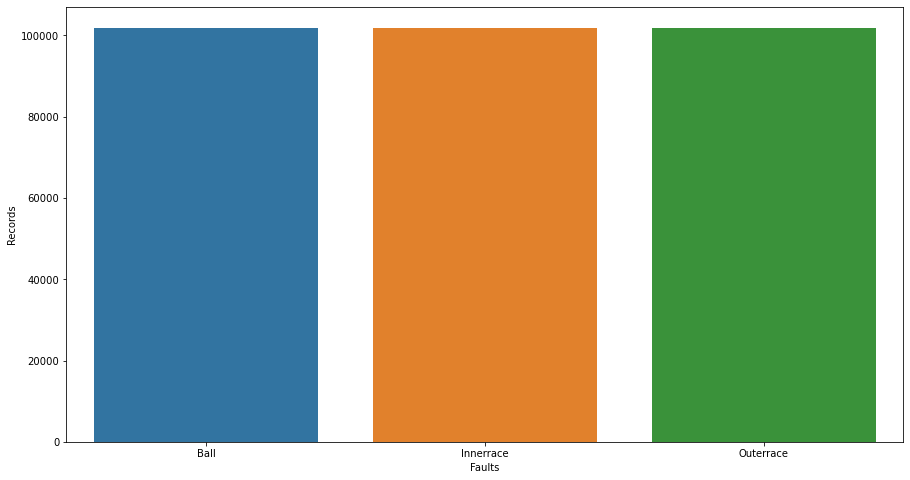

In [16]:
sns.countplot(x = 'Faults', data=df)

# to save plots in high ddefinition 
#plt.savefig("../figures/class_distribution_beforedropouts.png")
plt.ylabel('Records')
plt.savefig(figuredir + "class_distribution_after_equal_distribution.png", bbox_inches='tight', dpi=600)
plt.show()

In [15]:
class2idx = {
    "Ball":0,
    "Innerrace":1,
    "Outerrace":2

}

idx2class = {v: k for k, v in class2idx.items()}

df['Faults'].replace(class2idx, inplace=True)
df['Faults'].unique()

array([0, 1, 2], dtype=int64)

In [16]:
# droping series
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
X.head() , y.head()

(      speed  vibration
 0  4.217042   0.003062
 1  4.219672   0.004049
 2  4.221645   0.001418
 3  0.036346  -0.002199
 4  0.036017  -0.003515,
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: Faults, dtype: int64)

In [17]:
y.unique() , len(y.unique())

(array([0, 1, 2], dtype=int64), 3)

In [1]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

NameError: name 'train_test_split' is not defined

In [19]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [20]:
def get_class_distribution(obj):
    count_dict = {
        
        "Ball" : 0,
        "Innerrace": 0,
        "Outerrace": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['Ball'] += 1
        elif i == 1: 
            count_dict['Innerrace'] += 1
        elif i == 2: 
            count_dict['Outerrace'] += 1  
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

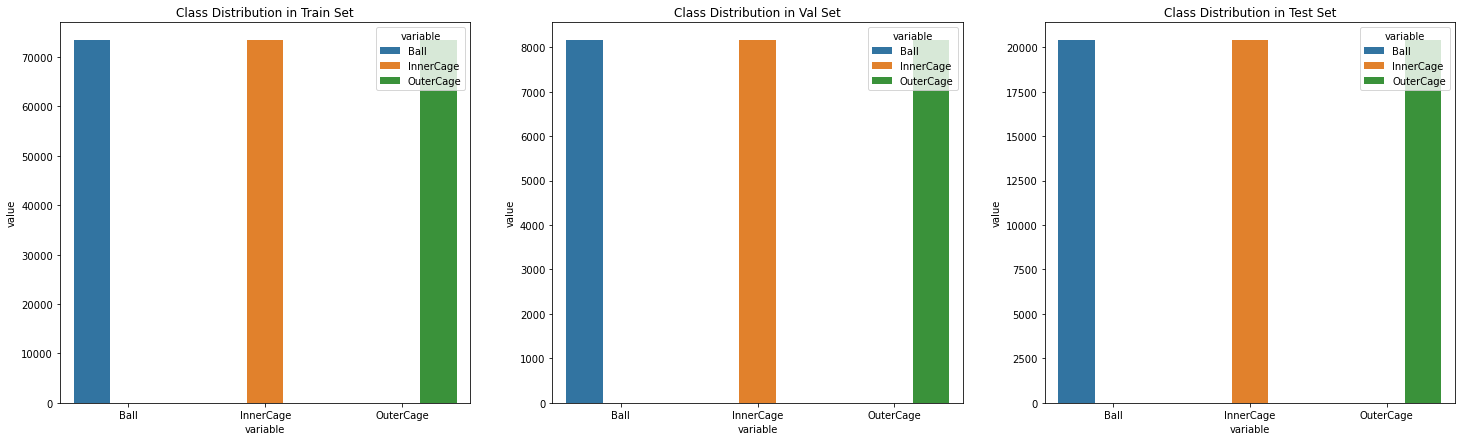

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [22]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [23]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [24]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)


tensor([1.3628e-05, 1.3628e-05, 1.3628e-05])


In [25]:
# https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
class_weights_all = class_weights[target_list]

In [26]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [27]:
#100 = 87% , 512/1024 batch

EPOCHS = 200
BATCH_SIZE = 1024
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = len(y.unique())
NUM_FEATURES , NUM_CLASSES

(2, 3)

In [28]:
"""

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])

https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274/4

You could set drop_last=True in your DataLoader and run your code again.
"""


train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,sampler=weighted_sampler , drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, drop_last=True)

In [29]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [31]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


MulticlassClassification(
  (layer_1): Linear(in_features=2, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [32]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [33]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [34]:
import progressbar
import time

from progressbar import AnimatedMarker, Bar, BouncingBar, Counter, ETA, \
    AdaptiveETA, FileTransferSpeed, FormatLabel, Percentage, \
    ProgressBar, ReverseBar, RotatingMarker, \
    SimpleProgress, Timer
max_barlenght = len(train_loader) + len(val_loader)
#bar = progressbar.ProgressBar(max_value= max_barlenght)
print(f'max_barlenght = {max_barlenght} | Train loader: {len(train_loader)} | Val loader: {len(val_loader)}')

#print("Begin training.")

max_barlenght = 24674 | Train loader: 214 | Val loader: 24460


In [35]:
print("Begin training.", flush=True ) # , flush=True will solve the issues with progress bar
#time.sleep(.5)
"""widgets = ['Test: ', Percentage(), ' ', Bar(marker=RotatingMarker()),
           ' ', ETA(), ' ', FileTransferSpeed()]"""
#for e in tqdm(range(1, EPOCHS+1)):
for e in range(EPOCHS):
    
    i = 0
    pbar = ProgressBar(widgets=[f'Epoch {e+1}',' ' ,
                                Bar('>'), ' ', Percentage(),' ',
                                Timer(), ' ' , ETA(),' ',
                                f'Training  {(e+1)/(EPOCHS)*100:.1f}%' ],
                       maxval= max_barlenght).start()
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:

        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        i = i+1
        pbar.update(i)
        #print(f'X_val_batch {len(X_val_batch)}')
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
       
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            #print(f' X_val_batch {X_val_batch}')
            i = i+1
            pbar.update(i)
            
    pbar.finish()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                             
    #print(f'Epoch { %('='*(60*(e+0:03)/10), (100*(e+0:03)/10))}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

    print(f'Epoch {e+1}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}', flush=True )
    #time.sleep(.5)

Begin training.


Epoch 1 |>>>>>>>>>>>>| 100% Elapsed Time: 0:00:37 Time:  0:00:37 Training  0.5%


Epoch 1: | Train Loss: 0.45244 | Val Loss: 0.39755 | Train Acc: 77.664| Val Acc: 82.052


Epoch 2 |>>>>>>>>>>>>| 100% Elapsed Time: 0:00:35 Time:  0:00:35 Training  1.0%


Epoch 2: | Train Loss: 0.38170 | Val Loss: 0.34817 | Train Acc: 80.523| Val Acc: 84.575


Epoch 3 |>>>>>>>>>>>>| 100% Elapsed Time: 0:00:36 Time:  0:00:36 Training  1.5%


Epoch 3: | Train Loss: 0.36278 | Val Loss: 0.32915 | Train Acc: 81.514| Val Acc: 84.358


Epoch 4 |>>>>>>>>>>>>| 100% Elapsed Time: 0:00:36 Time:  0:00:36 Training  2.0%


Epoch 4: | Train Loss: 0.35209 | Val Loss: 0.34175 | Train Acc: 82.093| Val Acc: 81.500


Epoch 5 |>>>>>>>>>>>>| 100% Elapsed Time: 0:00:38 Time:  0:00:38 Training  2.5%


Epoch 5: | Train Loss: 0.34537 | Val Loss: 0.31595 | Train Acc: 82.360| Val Acc: 84.894


Epoch 6 |>>>>>>>>>>>>| 100% Elapsed Time: 0:00:38 Time:  0:00:38 Training  3.0%


Epoch 6: | Train Loss: 0.34037 | Val Loss: 0.31101 | Train Acc: 82.701| Val Acc: 85.478


Epoch 7 |>>>>>>>>>>>>| 100% Elapsed Time: 0:00:38 Time:  0:00:38 Training  3.5%


Epoch 7: | Train Loss: 0.33314 | Val Loss: 0.30683 | Train Acc: 83.136| Val Acc: 85.425


Epoch 8 |>>>>>>>>>>>>| 100% Elapsed Time: 0:00:39 Time:  0:00:39 Training  4.0%


Epoch 8: | Train Loss: 0.32984 | Val Loss: 0.30858 | Train Acc: 83.280| Val Acc: 85.102


Epoch 9 |>>>>>>>>>>>>| 100% Elapsed Time: 0:00:38 Time:  0:00:38 Training  4.5%


Epoch 9: | Train Loss: 0.33186 | Val Loss: 0.30590 | Train Acc: 83.084| Val Acc: 85.253


Epoch 10 |>>>>>>>>>>>| 100% Elapsed Time: 0:00:39 Time:  0:00:39 Training  5.0%


Epoch 10: | Train Loss: 0.32755 | Val Loss: 0.30286 | Train Acc: 83.346| Val Acc: 84.804


Epoch 11 |>>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  5.5%


Epoch 11: | Train Loss: 0.32675 | Val Loss: 0.30676 | Train Acc: 83.416| Val Acc: 85.180


Epoch 12 |>>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  6.0%


Epoch 12: | Train Loss: 0.32528 | Val Loss: 0.29961 | Train Acc: 83.430| Val Acc: 85.311


Epoch 13 |>>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  6.5%


Epoch 13: | Train Loss: 0.31892 | Val Loss: 0.29704 | Train Acc: 83.893| Val Acc: 85.237


Epoch 14 |>>>>>>>>>>>| 100% Elapsed Time: 0:00:33 Time:  0:00:33 Training  7.0%


Epoch 14: | Train Loss: 0.31875 | Val Loss: 0.29840 | Train Acc: 83.893| Val Acc: 85.487


Epoch 15 |>>>>>>>>>>>| 100% Elapsed Time: 0:00:38 Time:  0:00:38 Training  7.5%


Epoch 15: | Train Loss: 0.31487 | Val Loss: 0.29546 | Train Acc: 84.042| Val Acc: 85.364


Epoch 16 |>>>>>>>>>>>| 100% Elapsed Time: 0:00:35 Time:  0:00:35 Training  8.0%


Epoch 16: | Train Loss: 0.31802 | Val Loss: 0.29386 | Train Acc: 83.855| Val Acc: 85.699


Epoch 17 |>>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  8.5%


Epoch 17: | Train Loss: 0.31550 | Val Loss: 0.29540 | Train Acc: 84.140| Val Acc: 85.482


Epoch 18 |>>>>>>>>>>>| 100% Elapsed Time: 0:00:35 Time:  0:00:35 Training  9.0%


Epoch 18: | Train Loss: 0.31280 | Val Loss: 0.29464 | Train Acc: 84.262| Val Acc: 85.229


Epoch 19 |>>>>>>>>>>>| 100% Elapsed Time: 0:00:34 Time:  0:00:34 Training  9.5%


Epoch 19: | Train Loss: 0.31428 | Val Loss: 0.29550 | Train Acc: 84.019| Val Acc: 85.392


Epoch 20 |>>>>>>>>>>| 100% Elapsed Time: 0:00:33 Time:  0:00:33 Training  10.0%


Epoch 20: | Train Loss: 0.30849 | Val Loss: 0.29325 | Train Acc: 84.453| Val Acc: 85.495


Epoch 21 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  10.5%


Epoch 21: | Train Loss: 0.30731 | Val Loss: 0.29100 | Train Acc: 84.505| Val Acc: 85.867


Epoch 22 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  11.0%


Epoch 22: | Train Loss: 0.30980 | Val Loss: 0.29413 | Train Acc: 84.346| Val Acc: 85.405


Epoch 23 |>>>>>>>>>>| 100% Elapsed Time: 0:00:33 Time:  0:00:33 Training  11.5%


Epoch 23: | Train Loss: 0.30946 | Val Loss: 0.29158 | Train Acc: 84.355| Val Acc: 85.552


Epoch 24 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  12.0%


Epoch 24: | Train Loss: 0.30627 | Val Loss: 0.28930 | Train Acc: 84.514| Val Acc: 85.687


Epoch 25 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  12.5%


Epoch 25: | Train Loss: 0.30659 | Val Loss: 0.29080 | Train Acc: 84.551| Val Acc: 85.630


Epoch 26 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  13.0%


Epoch 26: | Train Loss: 0.30366 | Val Loss: 0.28999 | Train Acc: 84.533| Val Acc: 86.047


Epoch 27 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  13.5%


Epoch 27: | Train Loss: 0.30533 | Val Loss: 0.28984 | Train Acc: 84.556| Val Acc: 85.867


Epoch 28 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  14.0%


Epoch 28: | Train Loss: 0.30305 | Val Loss: 0.28771 | Train Acc: 84.748| Val Acc: 86.169


Epoch 29 |>>>>>>>>>>| 100% Elapsed Time: 0:00:33 Time:  0:00:33 Training  14.5%


Epoch 29: | Train Loss: 0.30448 | Val Loss: 0.28798 | Train Acc: 84.626| Val Acc: 85.887


Epoch 30 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  15.0%


Epoch 30: | Train Loss: 0.30056 | Val Loss: 0.28723 | Train Acc: 84.794| Val Acc: 85.842


Epoch 31 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  15.5%


Epoch 31: | Train Loss: 0.30007 | Val Loss: 0.28909 | Train Acc: 84.897| Val Acc: 85.556


Epoch 32 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  16.0%


Epoch 32: | Train Loss: 0.29832 | Val Loss: 0.28830 | Train Acc: 85.014| Val Acc: 85.785


Epoch 33 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  16.5%


Epoch 33: | Train Loss: 0.30133 | Val Loss: 0.28660 | Train Acc: 84.907| Val Acc: 85.687


Epoch 34 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  17.0%


Epoch 34: | Train Loss: 0.29952 | Val Loss: 0.28483 | Train Acc: 84.967| Val Acc: 86.161


Epoch 35 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  17.5%


Epoch 35: | Train Loss: 0.29802 | Val Loss: 0.28805 | Train Acc: 85.061| Val Acc: 85.679


Epoch 36 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  18.0%


Epoch 36: | Train Loss: 0.29972 | Val Loss: 0.28609 | Train Acc: 84.785| Val Acc: 85.781


Epoch 37 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  18.5%


Epoch 37: | Train Loss: 0.29792 | Val Loss: 0.28822 | Train Acc: 84.935| Val Acc: 86.226


Epoch 38 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  19.0%


Epoch 38: | Train Loss: 0.29743 | Val Loss: 0.28502 | Train Acc: 85.051| Val Acc: 86.243


Epoch 39 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  19.5%


Epoch 39: | Train Loss: 0.29582 | Val Loss: 0.28759 | Train Acc: 85.224| Val Acc: 85.973


Epoch 40 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  20.0%


Epoch 40: | Train Loss: 0.29814 | Val Loss: 0.28397 | Train Acc: 85.000| Val Acc: 86.128


Epoch 41 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  20.5%


Epoch 41: | Train Loss: 0.29775 | Val Loss: 0.28542 | Train Acc: 85.103| Val Acc: 86.378


Epoch 42 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  21.0%


Epoch 42: | Train Loss: 0.29693 | Val Loss: 0.28609 | Train Acc: 85.028| Val Acc: 85.969


Epoch 43 |>>>>>>>>>>| 100% Elapsed Time: 0:00:33 Time:  0:00:33 Training  21.5%


Epoch 43: | Train Loss: 0.29429 | Val Loss: 0.28446 | Train Acc: 85.252| Val Acc: 85.940


Epoch 44 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  22.0%


Epoch 44: | Train Loss: 0.29660 | Val Loss: 0.28584 | Train Acc: 85.196| Val Acc: 85.695


Epoch 45 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  22.5%


Epoch 45: | Train Loss: 0.29391 | Val Loss: 0.28443 | Train Acc: 85.262| Val Acc: 85.879


Epoch 46 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  23.0%


Epoch 46: | Train Loss: 0.29631 | Val Loss: 0.28435 | Train Acc: 85.210| Val Acc: 86.251


Epoch 47 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  23.5%


Epoch 47: | Train Loss: 0.29604 | Val Loss: 0.28671 | Train Acc: 85.196| Val Acc: 85.650


Epoch 48 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  24.0%


Epoch 48: | Train Loss: 0.29554 | Val Loss: 0.28455 | Train Acc: 85.136| Val Acc: 86.251


Epoch 49 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  24.5%


Epoch 49: | Train Loss: 0.29288 | Val Loss: 0.28651 | Train Acc: 85.379| Val Acc: 85.662


Epoch 50 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  25.0%


Epoch 50: | Train Loss: 0.29380 | Val Loss: 0.28500 | Train Acc: 85.318| Val Acc: 86.071


Epoch 51 |>>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  25.5%


Epoch 51: | Train Loss: 0.29013 | Val Loss: 0.28368 | Train Acc: 85.523| Val Acc: 86.435


Epoch 52 |>>>>>>>>>>| 100% Elapsed Time: 0:00:33 Time:  0:00:33 Training  26.0%


Epoch 52: | Train Loss: 0.29174 | Val Loss: 0.28311 | Train Acc: 85.477| Val Acc: 86.214


Epoch 53 |>>>>>>>>>>| 100% Elapsed Time: 0:00:35 Time:  0:00:35 Training  26.5%


Epoch 53: | Train Loss: 0.29403 | Val Loss: 0.28307 | Train Acc: 85.285| Val Acc: 86.165


Epoch 54 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  27.0%


Epoch 54: | Train Loss: 0.29391 | Val Loss: 0.28415 | Train Acc: 85.425| Val Acc: 86.284


Epoch 55 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  27.5%


Epoch 55: | Train Loss: 0.28972 | Val Loss: 0.28554 | Train Acc: 85.514| Val Acc: 86.476


Epoch 56 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  28.0%


Epoch 56: | Train Loss: 0.29002 | Val Loss: 0.28229 | Train Acc: 85.565| Val Acc: 86.186


Epoch 57 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  28.5%


Epoch 57: | Train Loss: 0.29329 | Val Loss: 0.28222 | Train Acc: 85.458| Val Acc: 86.124


Epoch 58 |>>>>>>>>>>| 100% Elapsed Time: 0:00:33 Time:  0:00:33 Training  29.0%


Epoch 58: | Train Loss: 0.29145 | Val Loss: 0.28448 | Train Acc: 85.491| Val Acc: 86.337


Epoch 59 |>>>>>>>>>>| 100% Elapsed Time: 0:00:44 Time:  0:00:44 Training  29.5%


Epoch 59: | Train Loss: 0.29093 | Val Loss: 0.28365 | Train Acc: 85.673| Val Acc: 86.460


Epoch 60 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  30.0%


Epoch 60: | Train Loss: 0.29120 | Val Loss: 0.28862 | Train Acc: 85.495| Val Acc: 85.638


Epoch 61 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  30.5%


Epoch 61: | Train Loss: 0.29101 | Val Loss: 0.28235 | Train Acc: 85.584| Val Acc: 86.284


Epoch 62 |>>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  31.0%


Epoch 62: | Train Loss: 0.29018 | Val Loss: 0.28307 | Train Acc: 85.607| Val Acc: 85.985


Epoch 63 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  31.5%


Epoch 63: | Train Loss: 0.29183 | Val Loss: 0.28819 | Train Acc: 85.467| Val Acc: 85.650


Epoch 64 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  32.0%


Epoch 64: | Train Loss: 0.29110 | Val Loss: 0.28446 | Train Acc: 85.654| Val Acc: 86.051


Epoch 65 |>>>>>>>>>>| 100% Elapsed Time: 0:00:33 Time:  0:00:33 Training  32.5%


Epoch 65: | Train Loss: 0.29028 | Val Loss: 0.28206 | Train Acc: 85.547| Val Acc: 86.443


Epoch 66 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  33.0%


Epoch 66: | Train Loss: 0.29077 | Val Loss: 0.28197 | Train Acc: 85.537| Val Acc: 86.206


Epoch 67 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  33.5%


Epoch 67: | Train Loss: 0.28873 | Val Loss: 0.28519 | Train Acc: 85.710| Val Acc: 86.267


Epoch 68 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  34.0%


Epoch 68: | Train Loss: 0.29069 | Val Loss: 0.28194 | Train Acc: 85.617| Val Acc: 86.349


Epoch 69 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  34.5%


Epoch 69: | Train Loss: 0.28826 | Val Loss: 0.28004 | Train Acc: 85.706| Val Acc: 86.365


Epoch 70 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  35.0%


Epoch 70: | Train Loss: 0.28999 | Val Loss: 0.28144 | Train Acc: 85.706| Val Acc: 86.214


Epoch 71 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  35.5%


Epoch 71: | Train Loss: 0.28831 | Val Loss: 0.28096 | Train Acc: 85.864| Val Acc: 86.427


Epoch 72 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  36.0%


Epoch 72: | Train Loss: 0.28895 | Val Loss: 0.28109 | Train Acc: 85.640| Val Acc: 86.402


Epoch 73 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  36.5%


Epoch 73: | Train Loss: 0.28820 | Val Loss: 0.28249 | Train Acc: 85.734| Val Acc: 86.517


Epoch 74 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  37.0%


Epoch 74: | Train Loss: 0.28683 | Val Loss: 0.28506 | Train Acc: 85.813| Val Acc: 86.333


Epoch 75 |>>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  37.5%


Epoch 75: | Train Loss: 0.28779 | Val Loss: 0.28180 | Train Acc: 85.701| Val Acc: 86.639


Epoch 76 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  38.0%


Epoch 76: | Train Loss: 0.28622 | Val Loss: 0.28263 | Train Acc: 85.907| Val Acc: 86.844


Epoch 77 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  38.5%


Epoch 77: | Train Loss: 0.28648 | Val Loss: 0.28257 | Train Acc: 85.977| Val Acc: 86.149


Epoch 78 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  39.0%


Epoch 78: | Train Loss: 0.28559 | Val Loss: 0.28326 | Train Acc: 86.000| Val Acc: 86.586


Epoch 79 |>>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  39.5%


Epoch 79: | Train Loss: 0.28629 | Val Loss: 0.28300 | Train Acc: 85.893| Val Acc: 86.423


Epoch 80 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  40.0%


Epoch 80: | Train Loss: 0.28777 | Val Loss: 0.28108 | Train Acc: 85.850| Val Acc: 86.415


Epoch 81 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  40.5%


Epoch 81: | Train Loss: 0.28809 | Val Loss: 0.28244 | Train Acc: 85.771| Val Acc: 86.202


Epoch 82 |>>>>>>>>>>| 100% Elapsed Time: 0:00:38 Time:  0:00:38 Training  41.0%


Epoch 82: | Train Loss: 0.28787 | Val Loss: 0.28088 | Train Acc: 85.925| Val Acc: 86.464


Epoch 83 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  41.5%


Epoch 83: | Train Loss: 0.28711 | Val Loss: 0.28096 | Train Acc: 85.790| Val Acc: 86.239


Epoch 84 |>>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  42.0%


Epoch 84: | Train Loss: 0.28529 | Val Loss: 0.29967 | Train Acc: 85.995| Val Acc: 85.482


Epoch 85 |>>>>>>>>>>| 100% Elapsed Time: 0:00:28 Time:  0:00:28 Training  42.5%


Epoch 85: | Train Loss: 0.28642 | Val Loss: 0.28307 | Train Acc: 85.930| Val Acc: 86.165


Epoch 86 |>>>>>>>>>>| 100% Elapsed Time: 0:00:28 Time:  0:00:28 Training  43.0%


Epoch 86: | Train Loss: 0.28671 | Val Loss: 0.28565 | Train Acc: 85.869| Val Acc: 86.182


Epoch 87 |>>>>>>>>>>| 100% Elapsed Time: 0:00:28 Time:  0:00:28 Training  43.5%


Epoch 87: | Train Loss: 0.28720 | Val Loss: 0.28292 | Train Acc: 85.818| Val Acc: 86.484


Epoch 88 |>>>>>>>>>>| 100% Elapsed Time: 0:00:34 Time:  0:00:34 Training  44.0%


Epoch 88: | Train Loss: 0.28521 | Val Loss: 0.28457 | Train Acc: 86.033| Val Acc: 86.018


Epoch 89 |>>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  44.5%


Epoch 89: | Train Loss: 0.28674 | Val Loss: 0.29457 | Train Acc: 85.794| Val Acc: 85.245


Epoch 90 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  45.0%


Epoch 90: | Train Loss: 0.28557 | Val Loss: 0.28369 | Train Acc: 85.958| Val Acc: 86.321


Epoch 91 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  45.5%


Epoch 91: | Train Loss: 0.28723 | Val Loss: 0.28076 | Train Acc: 85.888| Val Acc: 86.357


Epoch 92 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  46.0%


Epoch 92: | Train Loss: 0.28811 | Val Loss: 0.28203 | Train Acc: 85.822| Val Acc: 86.648


Epoch 93 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  46.5%


Epoch 93: | Train Loss: 0.28695 | Val Loss: 0.28317 | Train Acc: 85.836| Val Acc: 86.664


Epoch 94 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  47.0%


Epoch 94: | Train Loss: 0.28444 | Val Loss: 0.28279 | Train Acc: 86.005| Val Acc: 86.169


Epoch 95 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  47.5%


Epoch 95: | Train Loss: 0.28799 | Val Loss: 0.27989 | Train Acc: 85.841| Val Acc: 86.365


Epoch 96 |>>>>>>>>>>| 100% Elapsed Time: 0:00:33 Time:  0:00:33 Training  48.0%


Epoch 96: | Train Loss: 0.28486 | Val Loss: 0.29055 | Train Acc: 85.981| Val Acc: 85.940


Epoch 97 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  48.5%


Epoch 97: | Train Loss: 0.28510 | Val Loss: 0.28088 | Train Acc: 85.949| Val Acc: 86.374


Epoch 98 |>>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  49.0%


Epoch 98: | Train Loss: 0.28651 | Val Loss: 0.28244 | Train Acc: 85.897| Val Acc: 86.455


Epoch 99 |>>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  49.5%


Epoch 99: | Train Loss: 0.28720 | Val Loss: 0.27941 | Train Acc: 85.864| Val Acc: 86.558


Epoch 100 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  50.0%


Epoch 100: | Train Loss: 0.28557 | Val Loss: 0.28152 | Train Acc: 85.963| Val Acc: 86.370


Epoch 101 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  50.5%


Epoch 101: | Train Loss: 0.28331 | Val Loss: 0.28103 | Train Acc: 86.079| Val Acc: 86.333


Epoch 102 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  51.0%


Epoch 102: | Train Loss: 0.28650 | Val Loss: 0.28011 | Train Acc: 85.897| Val Acc: 86.656


Epoch 103 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  51.5%


Epoch 103: | Train Loss: 0.28597 | Val Loss: 0.29635 | Train Acc: 86.023| Val Acc: 85.924


Epoch 104 |>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  52.0%


Epoch 104: | Train Loss: 0.28457 | Val Loss: 0.28061 | Train Acc: 85.967| Val Acc: 86.316


Epoch 105 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  52.5%


Epoch 105: | Train Loss: 0.28527 | Val Loss: 0.27846 | Train Acc: 86.047| Val Acc: 86.611


Epoch 106 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  53.0%


Epoch 106: | Train Loss: 0.28446 | Val Loss: 0.28029 | Train Acc: 86.084| Val Acc: 86.787


Epoch 107 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  53.5%


Epoch 107: | Train Loss: 0.28446 | Val Loss: 0.27911 | Train Acc: 86.065| Val Acc: 86.460


Epoch 108 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  54.0%


Epoch 108: | Train Loss: 0.28296 | Val Loss: 0.28039 | Train Acc: 86.154| Val Acc: 86.447


Epoch 109 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  54.5%


Epoch 109: | Train Loss: 0.28412 | Val Loss: 0.27887 | Train Acc: 86.121| Val Acc: 86.639


Epoch 110 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  55.0%


Epoch 110: | Train Loss: 0.28502 | Val Loss: 0.27973 | Train Acc: 85.995| Val Acc: 86.496


Epoch 111 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  55.5%


Epoch 111: | Train Loss: 0.28488 | Val Loss: 0.28730 | Train Acc: 86.093| Val Acc: 86.271


Epoch 112 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  56.0%


Epoch 112: | Train Loss: 0.28598 | Val Loss: 0.28996 | Train Acc: 86.009| Val Acc: 85.454


Epoch 113 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  56.5%


Epoch 113: | Train Loss: 0.28448 | Val Loss: 0.28735 | Train Acc: 86.037| Val Acc: 86.341


Epoch 114 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  57.0%


Epoch 114: | Train Loss: 0.28423 | Val Loss: 0.27821 | Train Acc: 86.019| Val Acc: 86.693


Epoch 115 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  57.5%


Epoch 115: | Train Loss: 0.28452 | Val Loss: 0.27960 | Train Acc: 86.009| Val Acc: 86.631


Epoch 116 |>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  58.0%


Epoch 116: | Train Loss: 0.28282 | Val Loss: 0.27909 | Train Acc: 86.136| Val Acc: 86.566


Epoch 117 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  58.5%


Epoch 117: | Train Loss: 0.28274 | Val Loss: 0.28132 | Train Acc: 86.168| Val Acc: 86.321


Epoch 118 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  59.0%


Epoch 118: | Train Loss: 0.28524 | Val Loss: 0.28172 | Train Acc: 86.000| Val Acc: 86.018


Epoch 119 |>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  59.5%


Epoch 119: | Train Loss: 0.28319 | Val Loss: 0.27901 | Train Acc: 86.136| Val Acc: 86.447


Epoch 120 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  60.0%


Epoch 120: | Train Loss: 0.28330 | Val Loss: 0.28084 | Train Acc: 86.159| Val Acc: 86.361


Epoch 121 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  60.5%


Epoch 121: | Train Loss: 0.28372 | Val Loss: 0.27972 | Train Acc: 86.089| Val Acc: 86.913


Epoch 122 |>>>>>>>>>| 100% Elapsed Time: 0:00:33 Time:  0:00:33 Training  61.0%


Epoch 122: | Train Loss: 0.28428 | Val Loss: 0.28059 | Train Acc: 86.093| Val Acc: 86.590


Epoch 123 |>>>>>>>>>| 100% Elapsed Time: 0:00:35 Time:  0:00:35 Training  61.5%


Epoch 123: | Train Loss: 0.28379 | Val Loss: 0.27839 | Train Acc: 86.229| Val Acc: 86.447


Epoch 124 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  62.0%


Epoch 124: | Train Loss: 0.28340 | Val Loss: 0.27812 | Train Acc: 86.136| Val Acc: 86.476


Epoch 125 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  62.5%


Epoch 125: | Train Loss: 0.28237 | Val Loss: 0.28005 | Train Acc: 86.248| Val Acc: 86.885


Epoch 126 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  63.0%


Epoch 126: | Train Loss: 0.28654 | Val Loss: 0.28232 | Train Acc: 85.902| Val Acc: 86.570


Epoch 127 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  63.5%


Epoch 127: | Train Loss: 0.28419 | Val Loss: 0.28068 | Train Acc: 86.023| Val Acc: 86.243


Epoch 128 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  64.0%


Epoch 128: | Train Loss: 0.28393 | Val Loss: 0.28087 | Train Acc: 86.098| Val Acc: 86.648


Epoch 129 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  64.5%


Epoch 129: | Train Loss: 0.28145 | Val Loss: 0.27892 | Train Acc: 86.266| Val Acc: 86.832


Epoch 130 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  65.0%


Epoch 130: | Train Loss: 0.28303 | Val Loss: 0.27917 | Train Acc: 86.173| Val Acc: 86.235


Epoch 131 |>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  65.5%


Epoch 131: | Train Loss: 0.28501 | Val Loss: 0.27942 | Train Acc: 85.995| Val Acc: 86.566


Epoch 132 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  66.0%


Epoch 132: | Train Loss: 0.28186 | Val Loss: 0.28139 | Train Acc: 86.159| Val Acc: 86.239


Epoch 133 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  66.5%


Epoch 133: | Train Loss: 0.28234 | Val Loss: 0.28007 | Train Acc: 86.107| Val Acc: 86.619


Epoch 134 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  67.0%


Epoch 134: | Train Loss: 0.28101 | Val Loss: 0.28354 | Train Acc: 86.271| Val Acc: 86.296


Epoch 135 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  67.5%


Epoch 135: | Train Loss: 0.28189 | Val Loss: 0.28251 | Train Acc: 86.201| Val Acc: 86.554


Epoch 136 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  68.0%


Epoch 136: | Train Loss: 0.28396 | Val Loss: 0.27866 | Train Acc: 86.192| Val Acc: 86.451


Epoch 137 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  68.5%


Epoch 137: | Train Loss: 0.28358 | Val Loss: 0.28155 | Train Acc: 86.084| Val Acc: 86.570


Epoch 138 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  69.0%


Epoch 138: | Train Loss: 0.28020 | Val Loss: 0.27773 | Train Acc: 86.393| Val Acc: 86.386


Epoch 139 |>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  69.5%


Epoch 139: | Train Loss: 0.28291 | Val Loss: 0.27971 | Train Acc: 86.196| Val Acc: 86.697


Epoch 140 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  70.0%


Epoch 140: | Train Loss: 0.28288 | Val Loss: 0.28058 | Train Acc: 86.192| Val Acc: 86.427


Epoch 141 |>>>>>>>>>| 100% Elapsed Time: 0:00:33 Time:  0:00:33 Training  70.5%


Epoch 141: | Train Loss: 0.28193 | Val Loss: 0.27711 | Train Acc: 86.285| Val Acc: 86.672


Epoch 142 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  71.0%


Epoch 142: | Train Loss: 0.28100 | Val Loss: 0.27852 | Train Acc: 86.294| Val Acc: 86.656


Epoch 143 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  71.5%


Epoch 143: | Train Loss: 0.28381 | Val Loss: 0.27767 | Train Acc: 86.047| Val Acc: 86.668


Epoch 144 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  72.0%


Epoch 144: | Train Loss: 0.28130 | Val Loss: 0.27885 | Train Acc: 86.336| Val Acc: 86.709


Epoch 145 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  72.5%


Epoch 145: | Train Loss: 0.28218 | Val Loss: 0.28148 | Train Acc: 86.243| Val Acc: 86.476


Epoch 146 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  73.0%


Epoch 146: | Train Loss: 0.28109 | Val Loss: 0.27936 | Train Acc: 86.313| Val Acc: 86.554


Epoch 147 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  73.5%


Epoch 147: | Train Loss: 0.28127 | Val Loss: 0.27852 | Train Acc: 86.360| Val Acc: 86.333


Epoch 148 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  74.0%


Epoch 148: | Train Loss: 0.28341 | Val Loss: 0.27738 | Train Acc: 86.187| Val Acc: 86.643


Epoch 149 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  74.5%


Epoch 149: | Train Loss: 0.28427 | Val Loss: 0.28108 | Train Acc: 86.145| Val Acc: 86.316


Epoch 150 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  75.0%


Epoch 150: | Train Loss: 0.28232 | Val Loss: 0.27746 | Train Acc: 86.210| Val Acc: 86.623


Epoch 151 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  75.5%


Epoch 151: | Train Loss: 0.28316 | Val Loss: 0.27909 | Train Acc: 86.173| Val Acc: 86.566


Epoch 152 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  76.0%


Epoch 152: | Train Loss: 0.28190 | Val Loss: 0.27857 | Train Acc: 86.131| Val Acc: 86.562


Epoch 153 |>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  76.5%


Epoch 153: | Train Loss: 0.28168 | Val Loss: 0.28254 | Train Acc: 86.192| Val Acc: 86.141


Epoch 154 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  77.0%


Epoch 154: | Train Loss: 0.28312 | Val Loss: 0.28077 | Train Acc: 86.117| Val Acc: 86.504


Epoch 155 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  77.5%


Epoch 155: | Train Loss: 0.28114 | Val Loss: 0.27859 | Train Acc: 86.215| Val Acc: 86.586


Epoch 156 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  78.0%


Epoch 156: | Train Loss: 0.28261 | Val Loss: 0.27804 | Train Acc: 86.201| Val Acc: 86.558


Epoch 157 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  78.5%


Epoch 157: | Train Loss: 0.28262 | Val Loss: 0.27857 | Train Acc: 86.220| Val Acc: 86.811


Epoch 158 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  79.0%


Epoch 158: | Train Loss: 0.28200 | Val Loss: 0.28658 | Train Acc: 86.178| Val Acc: 85.760


Epoch 159 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  79.5%


Epoch 159: | Train Loss: 0.28262 | Val Loss: 0.27789 | Train Acc: 86.168| Val Acc: 86.766


Epoch 160 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  80.0%


Epoch 160: | Train Loss: 0.28157 | Val Loss: 0.27993 | Train Acc: 86.290| Val Acc: 86.795


Epoch 161 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  80.5%


Epoch 161: | Train Loss: 0.28077 | Val Loss: 0.27920 | Train Acc: 86.383| Val Acc: 86.742


Epoch 162 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  81.0%


Epoch 162: | Train Loss: 0.28101 | Val Loss: 0.27851 | Train Acc: 86.336| Val Acc: 86.713


Epoch 163 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  81.5%


Epoch 163: | Train Loss: 0.28161 | Val Loss: 0.27883 | Train Acc: 86.280| Val Acc: 86.574


Epoch 164 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  82.0%


Epoch 164: | Train Loss: 0.28069 | Val Loss: 0.27697 | Train Acc: 86.262| Val Acc: 86.742


Epoch 165 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  82.5%


Epoch 165: | Train Loss: 0.28265 | Val Loss: 0.27938 | Train Acc: 86.243| Val Acc: 86.370


Epoch 166 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  83.0%


Epoch 166: | Train Loss: 0.28057 | Val Loss: 0.28704 | Train Acc: 86.364| Val Acc: 86.149


Epoch 167 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  83.5%


Epoch 167: | Train Loss: 0.28089 | Val Loss: 0.28233 | Train Acc: 86.266| Val Acc: 86.365


Epoch 168 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  84.0%


Epoch 168: | Train Loss: 0.27944 | Val Loss: 0.27782 | Train Acc: 86.299| Val Acc: 86.623


Epoch 169 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  84.5%


Epoch 169: | Train Loss: 0.28168 | Val Loss: 0.27981 | Train Acc: 86.308| Val Acc: 86.705


Epoch 170 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  85.0%


Epoch 170: | Train Loss: 0.28022 | Val Loss: 0.27646 | Train Acc: 86.383| Val Acc: 86.930


Epoch 171 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  85.5%


Epoch 171: | Train Loss: 0.28238 | Val Loss: 0.27975 | Train Acc: 86.304| Val Acc: 86.721


Epoch 172 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  86.0%


Epoch 172: | Train Loss: 0.28205 | Val Loss: 0.27920 | Train Acc: 86.238| Val Acc: 86.611


Epoch 173 |>>>>>>>>>| 100% Elapsed Time: 0:00:33 Time:  0:00:33 Training  86.5%


Epoch 173: | Train Loss: 0.28102 | Val Loss: 0.28451 | Train Acc: 86.407| Val Acc: 86.161


Epoch 174 |>>>>>>>>>| 100% Elapsed Time: 0:00:34 Time:  0:00:34 Training  87.0%


Epoch 174: | Train Loss: 0.28150 | Val Loss: 0.27674 | Train Acc: 86.266| Val Acc: 86.881


Epoch 175 |>>>>>>>>>| 100% Elapsed Time: 0:00:34 Time:  0:00:34 Training  87.5%


Epoch 175: | Train Loss: 0.28286 | Val Loss: 0.27820 | Train Acc: 86.150| Val Acc: 86.713


Epoch 176 |>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  88.0%


Epoch 176: | Train Loss: 0.28031 | Val Loss: 0.27708 | Train Acc: 86.355| Val Acc: 86.496


Epoch 177 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  88.5%


Epoch 177: | Train Loss: 0.28046 | Val Loss: 0.28025 | Train Acc: 86.364| Val Acc: 86.607


Epoch 178 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  89.0%


Epoch 178: | Train Loss: 0.28183 | Val Loss: 0.27961 | Train Acc: 86.383| Val Acc: 86.860


Epoch 179 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  89.5%


Epoch 179: | Train Loss: 0.27963 | Val Loss: 0.27933 | Train Acc: 86.472| Val Acc: 86.545


Epoch 180 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  90.0%


Epoch 180: | Train Loss: 0.27981 | Val Loss: 0.27919 | Train Acc: 86.425| Val Acc: 86.680


Epoch 181 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  90.5%


Epoch 181: | Train Loss: 0.27985 | Val Loss: 0.28782 | Train Acc: 86.388| Val Acc: 85.977


Epoch 182 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  91.0%


Epoch 182: | Train Loss: 0.27970 | Val Loss: 0.27887 | Train Acc: 86.397| Val Acc: 86.308


Epoch 183 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  91.5%


Epoch 183: | Train Loss: 0.28071 | Val Loss: 0.27641 | Train Acc: 86.364| Val Acc: 86.807


Epoch 184 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  92.0%


Epoch 184: | Train Loss: 0.28193 | Val Loss: 0.28090 | Train Acc: 86.322| Val Acc: 86.394


Epoch 185 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  92.5%


Epoch 185: | Train Loss: 0.27823 | Val Loss: 0.27916 | Train Acc: 86.523| Val Acc: 86.648


Epoch 186 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  93.0%


Epoch 186: | Train Loss: 0.27930 | Val Loss: 0.27684 | Train Acc: 86.374| Val Acc: 86.787


Epoch 187 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  93.5%


Epoch 187: | Train Loss: 0.27927 | Val Loss: 0.27812 | Train Acc: 86.495| Val Acc: 86.545


Epoch 188 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  94.0%


Epoch 188: | Train Loss: 0.27730 | Val Loss: 0.27475 | Train Acc: 86.551| Val Acc: 86.852


Epoch 189 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  94.5%


Epoch 189: | Train Loss: 0.28160 | Val Loss: 0.27801 | Train Acc: 86.397| Val Acc: 86.648


Epoch 190 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  95.0%


Epoch 190: | Train Loss: 0.27890 | Val Loss: 0.28142 | Train Acc: 86.467| Val Acc: 86.222


Epoch 191 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  95.5%


Epoch 191: | Train Loss: 0.27866 | Val Loss: 0.28072 | Train Acc: 86.505| Val Acc: 86.570


Epoch 192 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  96.0%


Epoch 192: | Train Loss: 0.27832 | Val Loss: 0.27922 | Train Acc: 86.463| Val Acc: 86.652


Epoch 193 |>>>>>>>>>| 100% Elapsed Time: 0:00:32 Time:  0:00:32 Training  96.5%


Epoch 193: | Train Loss: 0.27850 | Val Loss: 0.27629 | Train Acc: 86.519| Val Acc: 86.688


Epoch 194 |>>>>>>>>>| 100% Elapsed Time: 0:00:31 Time:  0:00:31 Training  97.0%


Epoch 194: | Train Loss: 0.28076 | Val Loss: 0.27717 | Train Acc: 86.322| Val Acc: 86.872


Epoch 195 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  97.5%


Epoch 195: | Train Loss: 0.27791 | Val Loss: 0.27551 | Train Acc: 86.589| Val Acc: 86.729


Epoch 196 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  98.0%


Epoch 196: | Train Loss: 0.27944 | Val Loss: 0.27968 | Train Acc: 86.407| Val Acc: 86.750


Epoch 197 |>>>>>>>>>| 100% Elapsed Time: 0:00:29 Time:  0:00:29 Training  98.5%


Epoch 197: | Train Loss: 0.27997 | Val Loss: 0.27980 | Train Acc: 86.407| Val Acc: 86.447


Epoch 198 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  99.0%


Epoch 198: | Train Loss: 0.27909 | Val Loss: 0.27649 | Train Acc: 86.421| Val Acc: 86.709


Epoch 199 |>>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  99.5%


Epoch 199: | Train Loss: 0.27818 | Val Loss: 0.28413 | Train Acc: 86.575| Val Acc: 85.891


Epoch 200 |>>>>>>>>| 100% Elapsed Time: 0:00:30 Time:  0:00:30 Training  100.0%


Epoch 200: | Train Loss: 0.28126 | Val Loss: 0.27947 | Train Acc: 86.369| Val Acc: 86.586


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

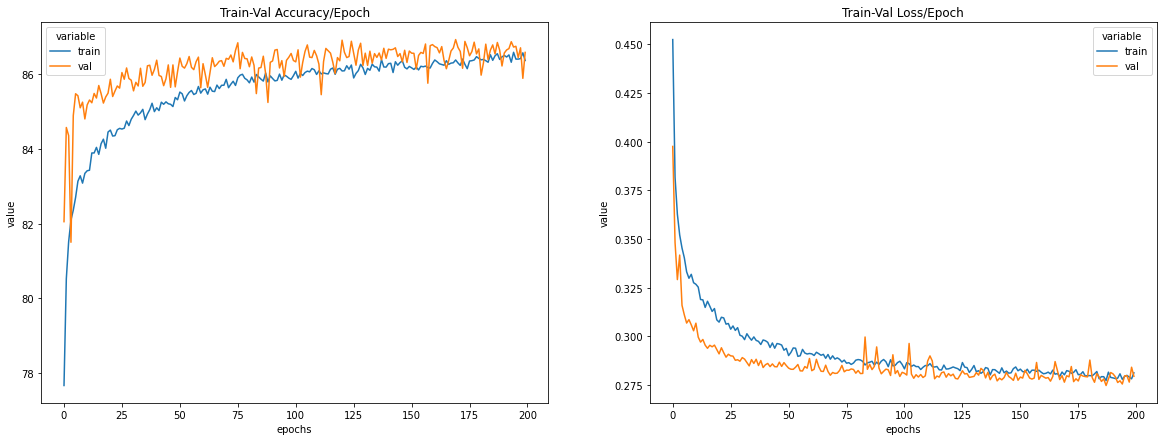

In [36]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')

sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')


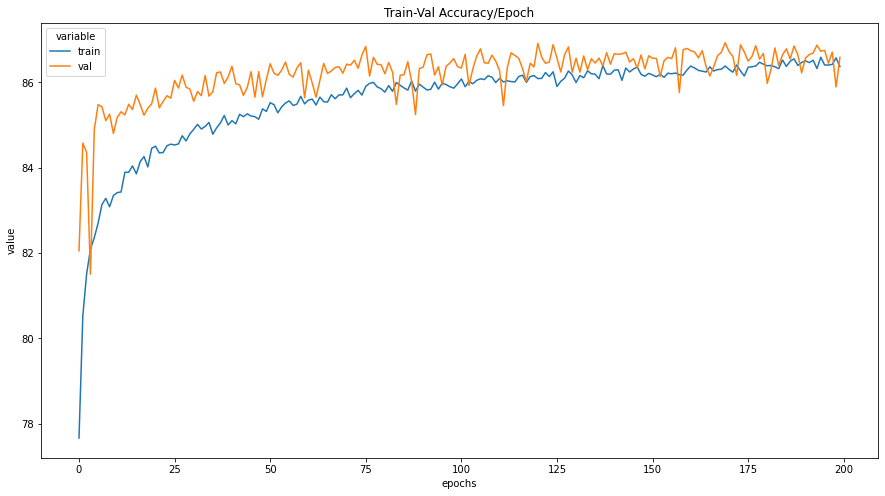

In [37]:
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable")

plt.title('Train-Val Accuracy/Epoch')

#,  ax=axes[0]).set_title('Train-Val Accuracy/Epoch'


plt.savefig(figuredir + "Train-Val Accuracy_Epoch.png", bbox_inches='tight', dpi=600)
plt.show()

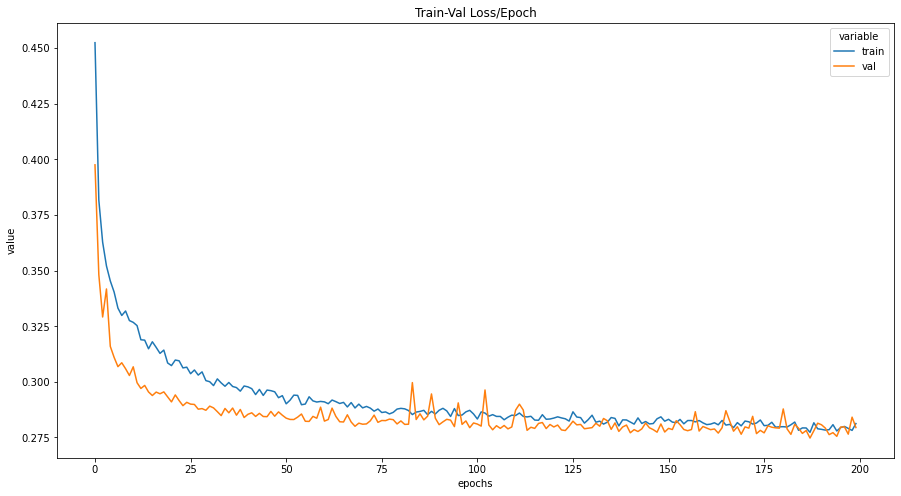

In [38]:
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable")

plt.title('Train-Val Loss/Epoch')

#,  ax=axes[0]).set_title('Train-Val Accuracy/Epoch'


plt.savefig(figuredir + "Train-Val Loss_Epoch.png", bbox_inches='tight', dpi=600)
plt.show()

In [39]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot:>

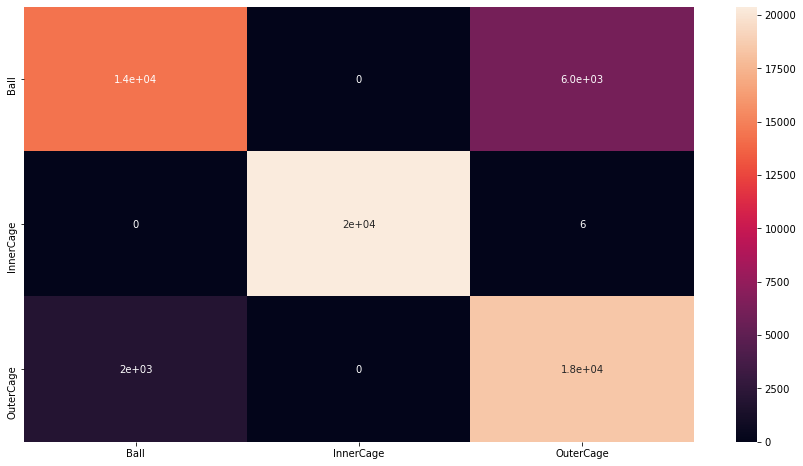

In [40]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [41]:
print(confusion_matrix_df)

            Ball  InnerCage  OuterCage
Ball       14333          0       6050
InnerCage      0      20378          6
OuterCage   1980          0      18404


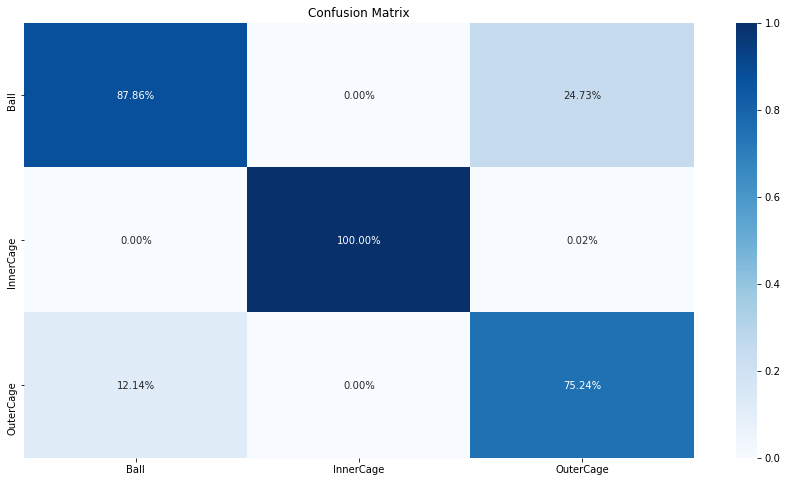

In [42]:
sns.heatmap(confusion_matrix_df/np.sum(confusion_matrix_df), annot=True, 
            fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix')

#,  ax=axes[0]).set_title('Train-Val Accuracy/Epoch'


plt.savefig(figuredir + "confusion_matrix1.png", bbox_inches='tight', dpi=600)
plt.show()


In [43]:
target_names = { k for k, v in class2idx.items()}
f1score = classification_report(y_test, y_pred_list, target_names=target_names)
print(f1score)

              precision    recall  f1-score   support

   OuterCage       0.88      0.70      0.78     20383
   InnerCage       1.00      1.00      1.00     20384
        Ball       0.75      0.90      0.82     20384

    accuracy                           0.87     61151
   macro avg       0.88      0.87      0.87     61151
weighted avg       0.88      0.87      0.87     61151

